# Loki Decompose - TNBC Sample
This notebook demonstrates how to run *Loki Decompose* on the in-house triple-negative breast cancer (TNBC) sample. It takes about 1 min to run this notebook on MacBook Pro.

In [1]:
import pandas as pd
import os
import scanpy as sc

import loki.decompose
# sc.settings.set_figure_params(dpi=, facecolor="white")

We first finetune OmiCLIP model on the pseudo Visium data in one of four sample region.

In [2]:
%%script echo "Comment this line to fine-tune the model on the TNBC data."

import subprocess
import open_clip

model_name='coca_ViT-L-14'
pretrained_weight_path='path to the omiclip pretrained weight'
train_csv = 'visium_data/finetune_data.csv'
name = 'finetune_tnbc'

train_command = [
    'python', '-m', 'training.main',
    '--name', name,
    '--save-frequency', '5',
    '--zeroshot-frequency', '10',
    '--report-to', 'wandb',
    '--train-data', train_csv,
    '--csv-img-key', 'img_path',
    '--csv-caption-key', 'label',
    '--warmup', '10',
    '--batch-size', '64',
    '--lr', '5e-6',
    '--wd', '0.1',
    '--epochs', '5',
    '--workers', '16',
    '--model', model_name,
    '--csv-separator', ',',
    '--pretrained', pretrained_weight_path,
    '--lock-text-freeze-layer-norm',
    '--lock-image-freeze-bn-stats',
    '--coca-caption-loss-weight','0',
    '--coca-contrastive-loss-weight','1',
    '--val-frequency', '10',
    '--aug-cfg', 'color_jitter=(0.32, 0.32, 0.32, 0.08)', 'color_jitter_prob=0.5', 'gray_scale_prob=0'
]

subprocess.run(train_command)

Comment this line to fine-tune the model on the TNBC data.


We provide the embeddings generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_decompose/TNBC_data`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the cell type decomposition on the pseudo Visium data:
```
    .                                                                                                                       
    ├── checkpoint_tnbc                                                                                                 
    │   ├── TNBC_img_features_finetune.csv                                                                                           
    │   ├── TNBC_txt_features_finetune.csv                                                                              
    │   └── TNBC_txt_features_sc_finetune.csv                                                                                      
    ├── scRNA_data                                                                                                          
    │   └── scRNA_data.h5ad                                                                                                                           
    └── pseudo_visium_data                                                                                                     
        ├── TNBC_pseudo_Visium.h5ad                                                                                            
        └── TNBC_Xenium_celltype_spot.h5ad                                            
```

In [5]:
data_path = './data/loki_decompose/TNBC_data/'
sample_name = 'TNBC'

In [6]:
def generate_deconv_df(sc_ad, st_ad):
    for cell_type in st_ad.obsm['tangram_ct_pred'].columns:
        st_ad.obsm['tangram_ct_pred'][cell_type]=st_ad.obsm['tangram_ct_pred'][cell_type]*sc_ad.obs['cell_type'].value_counts()[cell_type]
    
    st_ad.obsm['tangram_ct_pred']['Immune']=st_ad.obsm['tangram_ct_pred']['Macrophage']+ \
                                                st_ad.obsm['tangram_ct_pred']['B cell'] + \
                                                st_ad.obsm['tangram_ct_pred']['T cell']
    st_ad.obsm['tangram_ct_pred'].drop(['Macrophage','B cell','T cell'],axis=1, inplace=True)
    st_ad.obsm['tangram_ct_pred'] = st_ad.obsm['tangram_ct_pred'][['Epithelial', 'Immune', 'Stroma']]
          
    deconv_df = st_ad.obsm['tangram_ct_pred'].T/st_ad.obsm['tangram_ct_pred'].T.sum()
    deconv_df = deconv_df.T

    return deconv_df

In [7]:
sc_data_raw = sc.read_h5ad(os.path.join(data_path, 'scRNA_data', 'TNBC_SC_preprocess.h5ad'))
ad_vis = sc.read_h5ad(os.path.join(data_path, 'pseudo_visium_data', 'TNBC_pseudo_Visium.h5ad'))

Visualize cell type component defined by Xenium data (ground truth data).

In [8]:
ad_xen_sp = sc.read_h5ad(os.path.join(data_path, 'pseudo_visium_data', 'TNBC_Xenium_celltype_spot.h5ad'))
raw_deconv = ad_xen_sp.obs.pivot_table(index='spot', columns='cell_type', aggfunc='size').reindex(ad_vis.obs.index).T
raw_deconv = raw_deconv/raw_deconv.sum(axis=0)
raw_deconv = raw_deconv.T
raw_deconv

cell_type,Epithelial,Immune,Stroma
TNBC_processed_adata_AACACGTGCATCGCAC-1,0.000000,1.000000,0.000000
TNBC_processed_adata_AACACTTGGCAAGGAA-1,0.750000,0.250000,0.000000
TNBC_processed_adata_AACAGGAAGAGCATAG-1,0.772727,0.000000,0.227273
TNBC_processed_adata_AACAGGATTCATAGTT-1,0.916667,0.083333,0.000000
TNBC_processed_adata_AACAGGTTATTGCACC-1,0.846154,0.153846,0.000000
...,...,...,...
TNBC_processed_adata_TGTTGGAACCTTCCGC-1,1.000000,0.000000,0.000000
TNBC_processed_adata_TGTTGGAACGAGGTCA-1,0.968750,0.000000,0.031250
TNBC_processed_adata_TGTTGGAAGCTCGGTA-1,0.793103,0.000000,0.206897
TNBC_processed_adata_TGTTGGATGGACTTCT-1,1.000000,0.000000,0.000000


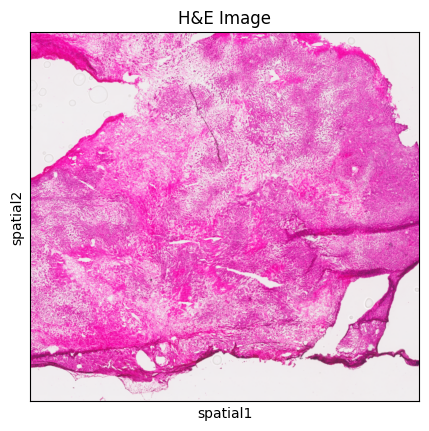

In [12]:
sc.pl.spatial(ad_vis, title='H&E Image')

In [13]:
ad_vis_copy = ad_vis.copy()
ad_vis_copy.obs = pd.concat([ad_vis_copy.obs,raw_deconv],axis=1)

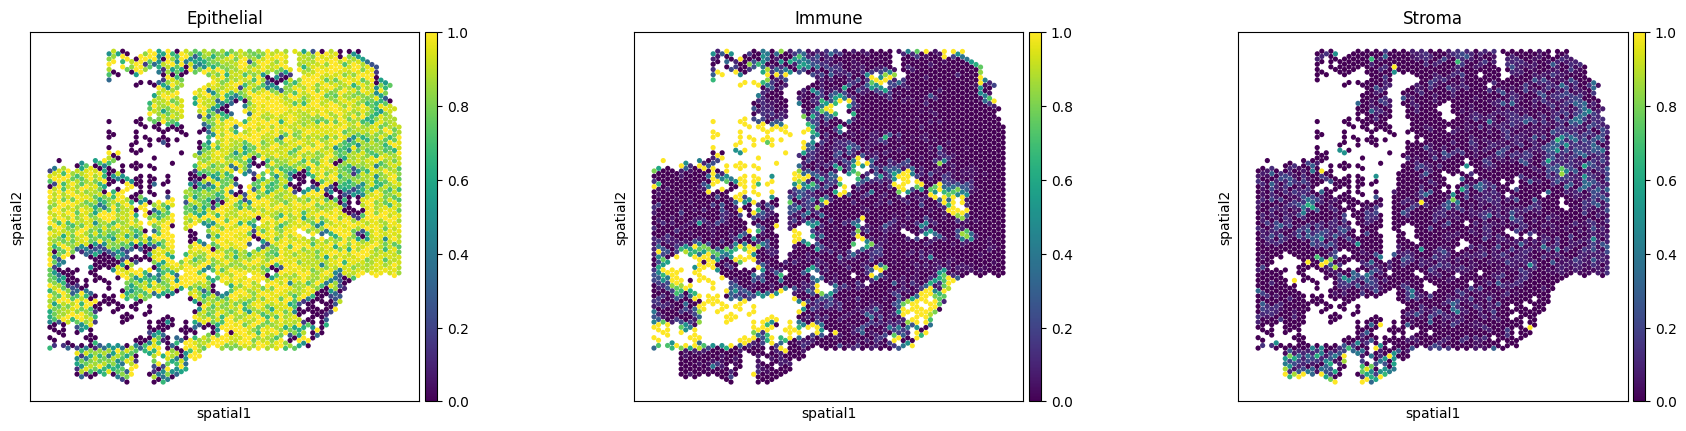

In [14]:
sc.pl.spatial(ad_vis_copy, color=['Epithelial', 'Immune', 'Stroma'], alpha_img=0, spot_size=400)

## Loki Decompose with fintuning
Run cell type decomposition using the pseudo Visium data.

In [15]:
case_name = '_finetune'
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

### Decompose ST data
Run cell type decomposition using the ST data.

In [16]:
sc_text_feature_path = os.path.join(data_path, 'checkpoint_tnbc', sample_name+'_txt_features_sc'+case_name+'.csv')
text_feature_path = os.path.join(data_path, 'checkpoint_tnbc', sample_name+'_txt_features'+case_name+'.csv')

sc_ad = loki.decompose.generate_feature_ad(sc_data, sc_text_feature_path, sc=True)
txt_ad = loki.decompose.generate_feature_ad(ad_expr, text_feature_path)

In [17]:
%%capture
txt_ad = loki.decompose.cell_type_decompose(sc_ad, txt_ad)

In [18]:
deconv_df = generate_deconv_df(sc_ad, txt_ad)
txt_ad.obs = pd.concat([txt_ad.obs, deconv_df], axis=1)

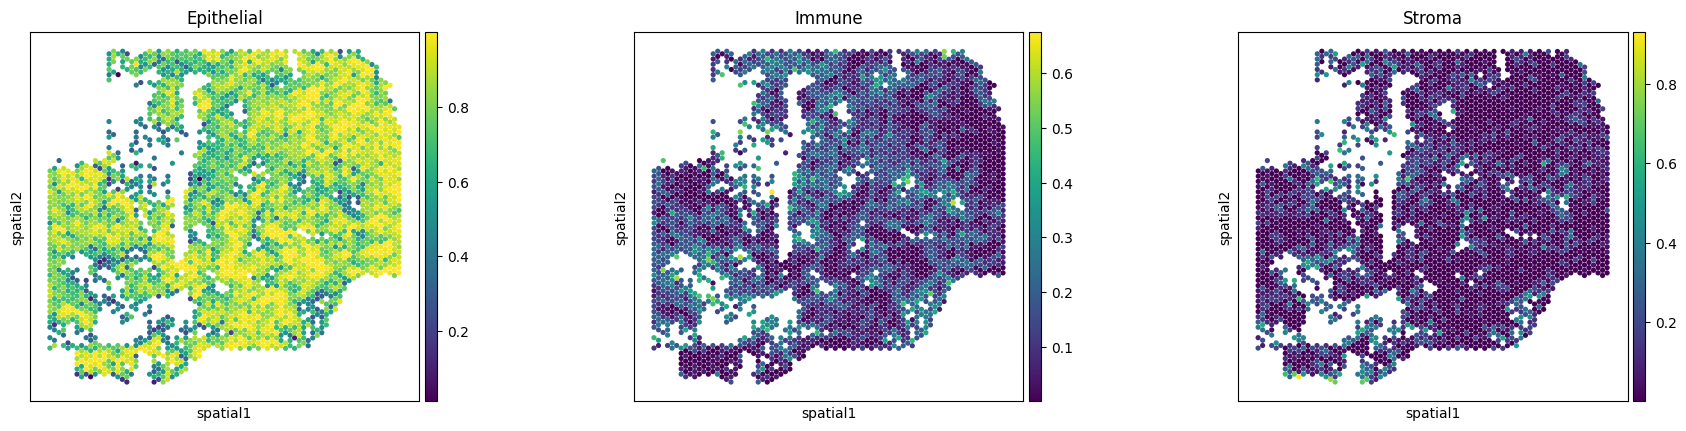

In [19]:
sc.pl.spatial(txt_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

### Decompose image
Run cell type decomposition using the image.

In [20]:
image_feature_path = os.path.join(data_path, 'checkpoint_tnbc', sample_name+'_img_features'+case_name+'.csv')
sc_ad = loki.decompose.generate_feature_ad(sc_data, sc_text_feature_path, sc=True)
img_ad = loki.decompose.generate_feature_ad(ad_expr, image_feature_path)

In [21]:
%%capture
img_ad = loki.decompose.cell_type_decompose(sc_ad, img_ad)

In [22]:
deconv_df = generate_deconv_df(sc_ad, img_ad)
img_ad.obs = pd.concat([img_ad.obs, deconv_df], axis=1)

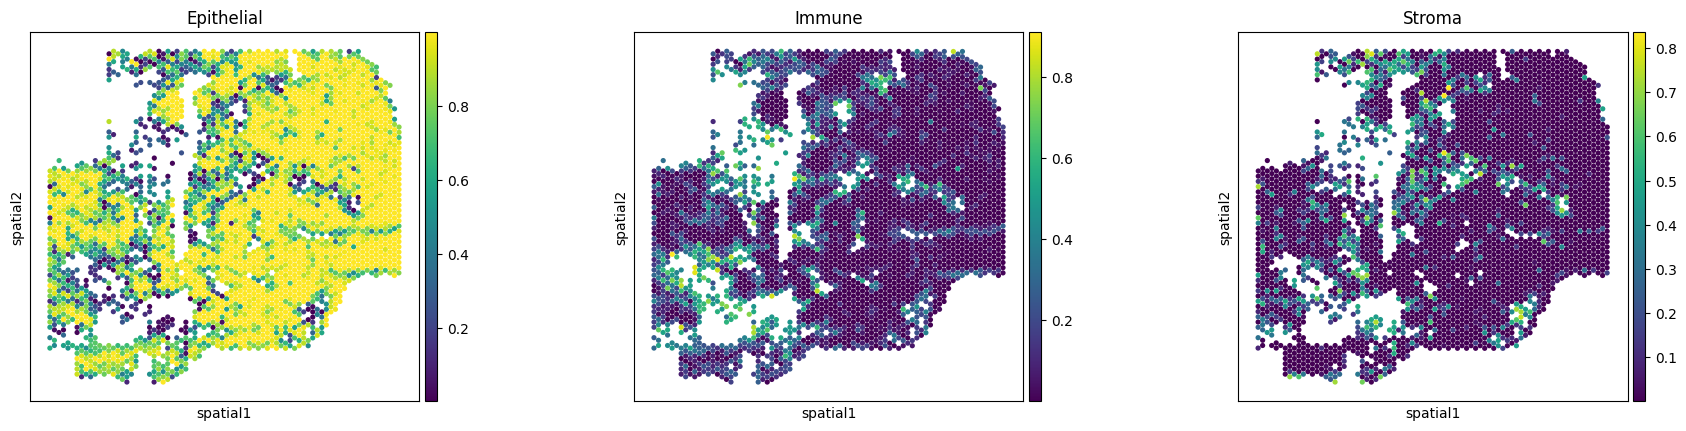

In [23]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)